In [0]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [0]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [29]:
## looks like its weekly data
y.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [30]:
y[y.isna().any(axis=1)]

,co2
1958-05-10,NaN
1958-05-31,NaN
1958-06-07,NaN
1958-06-14,NaN
1958-06-21,NaN
1958-06-28,NaN
1958-08-23,NaN
1958-09-13,NaN
1958-09-20,NaN
1958-09-27,NaN


In [0]:
# resampling to monthly data and taking the mean for the month
y = y['co2'].resample('MS').mean()
y = y = y.fillna(y.bfill())

In [32]:
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

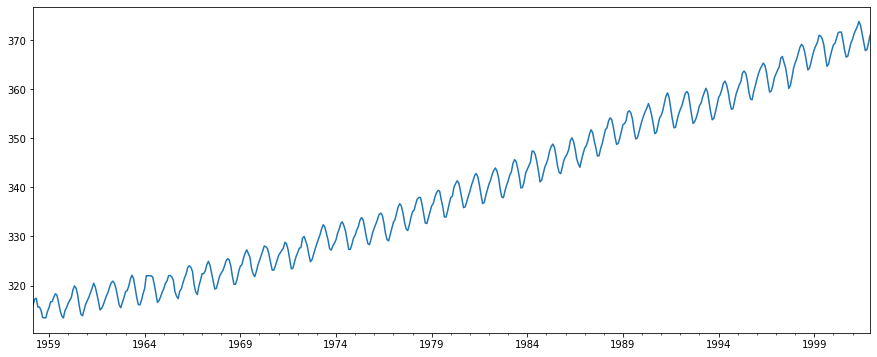

In [33]:
y.plot(figsize=(15, 6))
plt.show()

### Is it Stationary?
Identifying whether a time series is stationary or non-stationary is very important. If it is stationary you can use ARMA models to predict the next values of the time series.

#### Augmented Dicky-Fuller
- The **null hypothesis** of the test is that the time series can be represented by a unit root, that it is **not stationary** (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

#### Taking the difference
try different techniques on taking the difference to make it stationary 
- `np.log(df)`*take the log*
- `np.sqrt(df)`*take the square root*
- `np.shift(1)/(df)` *Proportional change*

#### AR
AR(1) model: $y_t$ = $a_1y_{t-1}$ + $\epsilon_t$

#### MA
MA(1) model: $y_t$ = $m_1\epsilon_{t-1}$ + $\epsilon_t$

#### ARMA = AR + MA
ARMA(1,1) model: $a_1y_{t-1}$ + $m_1\epsilon_{t-1}$ + $\epsilon_t$

ARMA(p,q)
   - p is order of AR part
   - q is order of MA part
   
When fitting and working with AR, MA and ARMA models it is very important to understand the model order. You will need to pick the model order when fitting. Picking this correctly will give you a better fitting model which makes better predictions. 


## Decomposing the time series

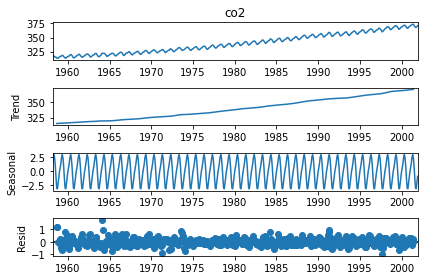

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(y)
decomp.plot()
plt.show()
# well the trend and season is very obvious

### Check for stationarity


In [35]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
# Print test statistic
print('test statistic is: ' + str(result[0]))

# Print p-value
print('p-value is ' + str(result[1]))

# Print critical values
print('Critical value is ' + str(result[4]))

# as expected, the time series wasn't stationary, so we will have to fix that via differencing

test statistic is: 2.3598099539953714
p-value is 0.9989901230798025
Critical value is {'1%': -3.4432119442564324, '5%': -2.8672126791646955, '10%': -2.569791324979607}


This is how a non stationary series would look like if you don't difference it..

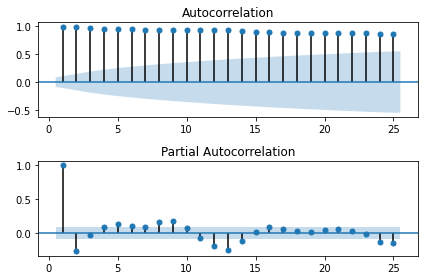

In [36]:
# Create figure and subplots
fig, (ax1,ax2) = plt.subplots(2,1)

# Plot the ACF
plot_acf(y, lags=25, zero=False, ax=ax1)
plot_pacf(y, lags=25, zero=False, ax=ax2)
# Show figure
plt.tight_layout()
plt.show()

Lets try to make it stationary

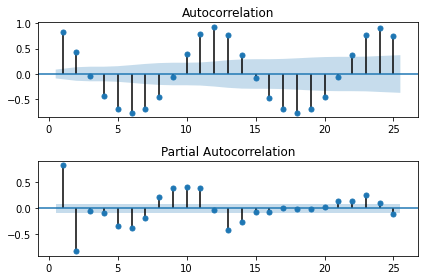

In [37]:
y_detrend = y - y.rolling(15).mean()
y_detrend = y_detrend.dropna()

# Create figure and subplots
fig, (ax1,ax2) = plt.subplots(2,1)

# Plot the ACF
plot_acf(y_detrend, lags=25, zero=False, ax=ax1)
plot_pacf(y_detrend, lags=25, zero=False, ax=ax2)
# Show figure
plt.tight_layout()
plt.show()
# beautiful time period of 12!

In [38]:
#Take the first order difference and the seasonal difference of the time series and drop the NaN values. 
#The seasonal period is 12 months.
y_diff = y.diff(1).diff(12).dropna()
result_diff = adfuller(y_diff)
print('test statistic is: ' + str(result_diff[0]))
print('p-value is ' + str(result_diff[1]))
print('Critical value is ' + str(result_diff[4]))

# looks like differencing once is good enough

test statistic is: -8.724891601521811
p-value is 3.308993777749871e-14
Critical value is {'1%': -3.4435761493506294, '5%': -2.867372960189225, '10%': -2.5698767442886696}


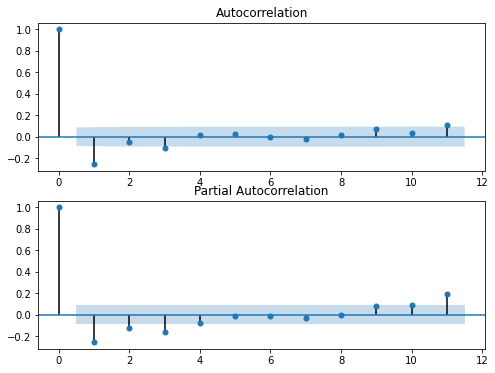

In [39]:
###############################
## Non Seasonal ACF and PACF ##
###############################

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(y_diff,lags=11, ax=ax1)

# Plot the PACF on ax2
plot_pacf(y_diff,lags=11, ax=ax2)

plt.show()

## Not quite sure if its AR, MA or ARMA just by looking at the graphs, could be ar1, ma1

##### How to choose SARIMA order?
|      |AR(p)|MA(q)|ARMA(p,q)|   |
|---   |---  |---|---|---|
|ACF   |Tails off   |Cuts off after lag q   |Tails off   |   |
|PACF  |Cuts off after lag p|Tails off|Tails off|   |

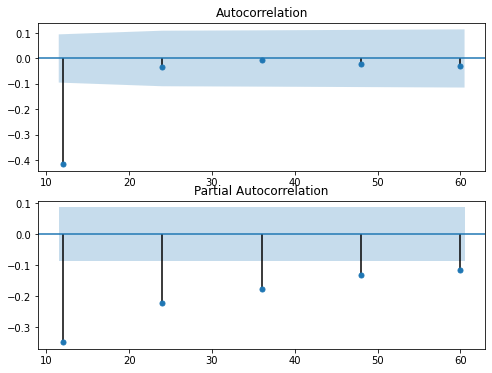

In [40]:
###########################
## Seasonal ACF and PACF ##
###########################

# Make list of lags to see get clues to seasonal AR & MA
lags = [12, 24, 36, 48, 60]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(y_diff, lags=lags,zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(y_diff, lags=lags,zero=False, ax=ax2)

plt.show()

# The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF
## The Seasonal ACF and PACF look like an MA(1) model seasonal

#### AIC & BIC
AIC - Akaike information criterion
- Lower AIC indicates a better model
- AIC likes to choose simple models with lower order

BIC - Bayesian information criterion
- Very similar to AIC
- Lower BIC indicates a better model
- BIC likes to choose simple models with lower order

Key Differences
- BIC favors simpler models than AIC
- AIC is better at choosing predictive models
- BIC is better at choosing good explanatory model

In [41]:
import pmdarima as pm 
model1 = pm.auto_arima(y,
                      seasonal=True, 
                      m=12, #m is seasonal period
                      d=1, D=1, 
                      max_p=2, max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 
model1.summary()

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,1,1,12) [intercept=True]; AIC=343.805, BIC=377.728, Time=11.263 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=635.791, BIC=644.272, Time=0.119 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=493.084, BIC=510.045, Time=1.799 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=350.496, BIC=367.457, Time=3.563 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=633.800, BIC=638.040, Time=0.061 seconds
Fit ARIMA(2,1,2)x(0,1,1,12) [intercept=True]; AIC=341.926, BIC=371.608, Time=9.866 seconds
Fit ARIMA(2,1,2)x(0,1,0,12) [intercept=True]; AIC=587.697, BIC=613.139, Time=1.574 seconds
Fit ARIMA(2,1,2)x(0,1,2,12) [intercept=True]; AIC=343.726, BIC=377.648, Time=24.392 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Fit ARIMA(2,1,2)x(1,1,0,12) [intercept=True]; AIC=478.660, BIC=508.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -164.273
Date:                            Thu, 28 May 2020   AIC                            338.545
Time:                                    13:51:30   BIC                            359.747
Sample:                                         0   HQIC                           346.856
                                            - 526                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      1.637      0.102      -0.000       0.002
ar.L1          0.4229      0.083      5.072      0.000       0.259       0.586
ma.L1         -0.7252      0.067    -10.804      0.000      -0.857      -0.594
ma.S.L12      -0.8815      0.026    -34.104      0.000      -0.932      -0.831
sigma2         0.1072      0.005     21.458      0.000       0.097       0.117
===================================================================================
Ljung-Box (Q):                       42.17   Jarque-Bera (JB):               116.59
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# auto arima said SARIMAX(1, 1, 1)x(0, 1, 1, 12)
mod = SARIMAX(y, 
            order = (1,1,1),
            seasonal_order=(0,1,1,12))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -165.748
Date:                            Thu, 28 May 2020   AIC                            339.497
Time:                                    13:51:32   BIC                            356.458
Sample:                                03-01-1958   HQIC                           346.145
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3974      0.085      4.652      0.000       0.230       0.565
ma.L1         -0.6994      0.069    -10.127      0.000      -0.835      -0.564
ma.S.L12      -0.8714      0.027    -32.058      0.000      -0.925      -0.818
sigma2         0.1080      0.005     21.763      0.000       0.098       0.118
===================================================================================
Ljung-Box (Q):                       39.80   Jarque-Bera (JB):               115.09
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

|Test   	|Null hypothesis   	|P-value name 	|   	|   	|
|---	|---	|---	|---	|---	|
|Ljung-Box   	|There are no correlations in the residual   	|Prob(Q)   	|   	|   	|
|Jarque-Bera   	|The residuals are normally distributed   	|Prob(JB)   	|   	|   	|


#### Plot diagnostics
|Test	|Good fit   	|   	|   	|   	|
|---	|---	|---	|---	|---	|
|Standardized residual   	|There are no obvious patterns in the residuals   	|   	|   	|   	|
|Histogram plus kde estimate   	|The KDE curve should be very similar to the normal distribution   	|   	|   	|   	|
|Normal Q-Q   	|Most of the data points should lie on the straight line   	|   	|   	|   	|
| Correlogram   |95% of correlations for lag greater than one should not be significant |   	|   	|   	|

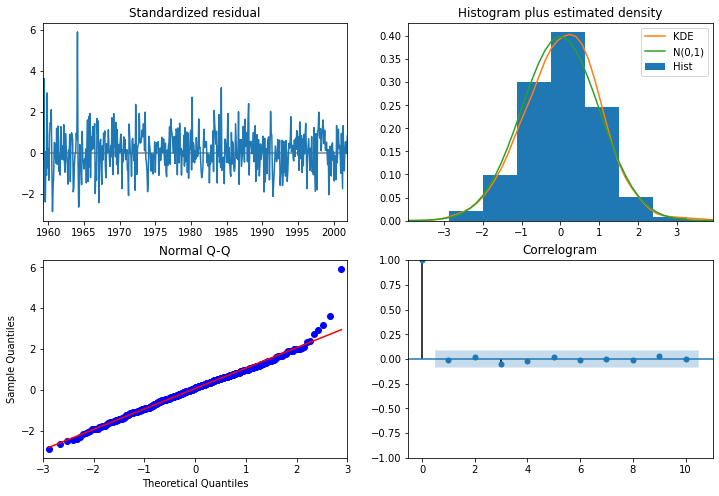

In [43]:
# the JB numbers are saying that my residuals are not normally distributed..
results.plot_diagnostics(figsize=(12,8))
plt.show()
# qq plot is not looking good either..

### Validating forecasts

In [44]:
y.tail()

2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, dtype: float64

#### **Dynamic forecasting**
a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

#### Non Dynamic forecast

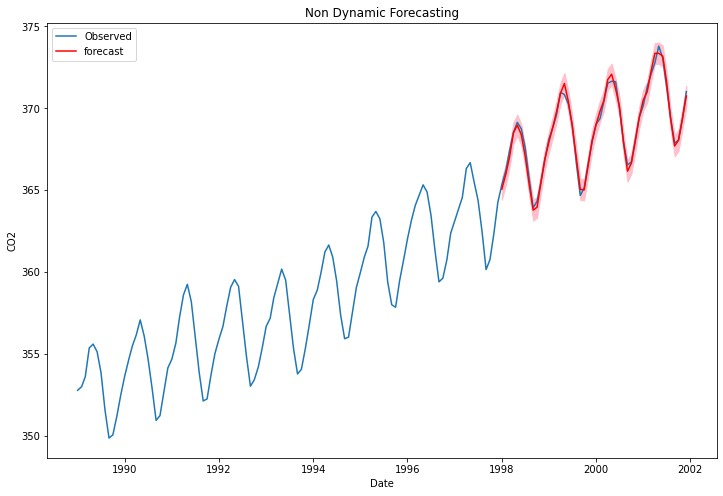

In [45]:
plt.figure(figsize=(12,8))
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
mean_forecast = pred.predicted_mean
pred_ci = pred.conf_int()

lower_limits = pred_ci.loc[:,'lower co2']
upper_limits = pred_ci.loc[:,'upper co2']

plt.plot(y['1989':].index, y['1989':], label='Observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')

plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Non Dynamic Forecasting')
plt.legend()
plt.show()

In [46]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.08


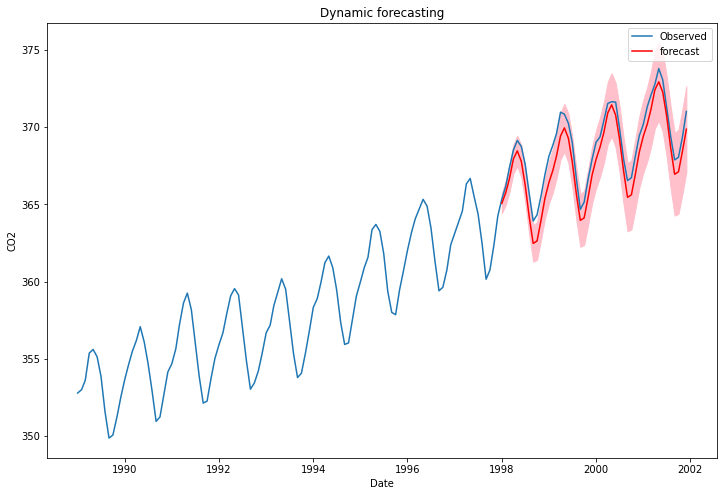

In [47]:
plt.figure(figsize=(12,8))
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True)
mean_forecast = pred.predicted_mean
pred_ci = pred.conf_int()

lower_limits = pred_ci.loc[:,'lower co2']
upper_limits = pred_ci.loc[:,'upper co2']

plt.plot(y['1989':].index, y['1989':], label='Observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')


plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Dynamic forecasting')
plt.legend()
plt.show()

In [48]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The MSE is a little worse off compared to non dynamic, which is to be expected given that we are relying on less historical data from the time series.

The Mean Squared Error of our forecasts is 1.11


#### **The Box-Jenkins method**
- Identification
    - Is the time series stationary?
        - `adfuller()` augmented Dicky-Fuller
    - What differencing will make it stationary?
    - What transforms will make it stationary?
        - df.diff(), np.log(), np.sqrt()
    - What values of p and q are most promising?
- estimation
    - choose between models using AIC and BIC
        - `results.aic`,`results.bic`
- model diagnostics
    - are residuals uncorrelated
    - are residuals normally distributed
        - `results.plot_diagnostics()`
        - `results.summary'
- ready to make forecasts
    - `results.get_forecast()`

#### **Box-Jenkins with seasonal data**
- Determine if time series is seasonal
- find seasonal period
- find transforms to make data stationary
    - seasonal and non-seasonal differencing
    - other transforms
    
#### Mixed differencing
- `D` should be 0 or 1
- `d + D` should be 0-2


**additive seasonality**
- additive series = trend + season
- proceed as usual with differencing

**multiplicative seasonality**
- multiplicative series = trend x season
- apply log transform first - `np.log`


[Other source](https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)<br>

[Anomaly Detection](https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Anomaly%20Detection.ipynb)